In [1]:
from torch.distributions import Categorical

import gym
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

In [6]:
gamma = 0.99

In [7]:
class Pi(nn.Module):
    """
        Constructs the policy network that is a a simple one-layer MLP with 64 hidden units
    """
    def __init__(self, in_dim, out_dim):
        super(Pi, self).__init__()
        layers = [
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
        ]

        self.model = nn.Sequential(*layers)
        self.onpolicy_reset()
        self.train()  # set training mode

    def onpolicy_reset(self):
        self.log_probs = []
        self.rewards = []

    def forward(self, x):
        pdparam = self.model(x)
        return pdparam

    def act(self, state):
        """
            Method to produce action
        """
        x = torch.from_numpy(state.astype(np.float32))  # to tensor
        pdparam = self.forward(x)  # forward pass
        pd = Categorical(logits=pdparam)  # probability distribution
        action = pd.sample()  # pi(a|s) in action via pd
        log_prob = pd.log_prob(action)  # log_prob of pi(a|s)
        self.log_probs.append(log_prob)  # store for training
        return action.item()

In [8]:
def train(pi, optimizer):
    """ 
      Inner gradient-ascent loop of REINFORCE algorithm.
      Implements the update steps
    """
    T = len(pi.rewards)
    rets = np.empty(T, dtype=np.float32)  # the returns
    future_ret = 0.0
    # compute the returns efficiently
    for t in reversed(range(T)):
        future_ret = pi.rewards[t] + gamma * future_ret
        rets[t] = future_ret

    rets = torch.tensor(rets)
    log_probs = torch.stack(pi.log_probs)
    loss = -log_probs * rets  # gradient term; Negative for maximizing
    loss = torch.sum(loss)
    optimizer.zero_grad()
    loss.backward()  # backpropagate, compute gradients
    optimizer.step()  # gradient-ascent, update the weights
    return loss

In [9]:
def main():
    """
        Constructs a CartPole environment, the policy network Pi, and an optimizer. 
        Then, it runs the training loop for 300 episodes. 
        As training progresses, the total reward per episode should increase towards 200. 
        The environment is solved when the total reward is above 195.
    """
    env = gym.make('CartPole-v0')
    in_dim = env.observation_space.shape[0]  # 4
    out_dim = env.action_space.n  # 2
    pi = Pi(
        in_dim, out_dim
    )  # policy pi_theta for REINFORCE 
    optimizer = optim.Adam(pi.parameters(), lr=0.01)

    for epi in range(300):
        state = env.reset()
        for t in range(200):  # cartpole max timestep is 200
            action = pi.act(state)
            state, reward, done, _ = env.step(action)
            pi.rewards.append(reward)
            env.render()
            if done:
                break

        loss = train(pi, optimizer)  # train per episode
        total_reward = sum(pi.rewards)
        solved = total_reward > 195.0
        pi.onpolicy_reset()  # onpolicy: clear memory after training
        print(f'Episode {epi}, loss: {loss}, total_reward: {total_reward}, solved: {solved}')


if __name__ == '__main__':
    main()

Episode 0, loss: 107.9350357055664, total_reward: 18.0, solved: False
Episode 1, loss: 674.29833984375, total_reward: 46.0, solved: False
Episode 2, loss: 86.43074035644531, total_reward: 16.0, solved: False
Episode 3, loss: 107.18008422851562, total_reward: 18.0, solved: False
Episode 4, loss: 170.1498565673828, total_reward: 23.0, solved: False
Episode 5, loss: 95.06501007080078, total_reward: 16.0, solved: False
Episode 6, loss: 215.02203369140625, total_reward: 26.0, solved: False
Episode 7, loss: 105.8284912109375, total_reward: 17.0, solved: False
Episode 8, loss: 110.7625503540039, total_reward: 18.0, solved: False
Episode 9, loss: 477.7502136230469, total_reward: 40.0, solved: False
Episode 10, loss: 170.65185546875, total_reward: 23.0, solved: False
Episode 11, loss: 75.96482849121094, total_reward: 14.0, solved: False
Episode 12, loss: 438.1299743652344, total_reward: 38.0, solved: False
Episode 13, loss: 67.99980163574219, total_reward: 14.0, solved: False
Episode 14, loss: 

Episode 117, loss: 103.94544982910156, total_reward: 19.0, solved: False
Episode 118, loss: 48.13018035888672, total_reward: 15.0, solved: False
Episode 119, loss: 6482.47509765625, total_reward: 200.0, solved: True
Episode 120, loss: 54.70405960083008, total_reward: 14.0, solved: False
Episode 121, loss: 4474.03515625, total_reward: 161.0, solved: False
Episode 122, loss: 49.687740325927734, total_reward: 14.0, solved: False
Episode 123, loss: 25.997417449951172, total_reward: 10.0, solved: False
Episode 124, loss: 68.6747055053711, total_reward: 16.0, solved: False
Episode 125, loss: 92.56329345703125, total_reward: 17.0, solved: False
Episode 126, loss: 20.582002639770508, total_reward: 10.0, solved: False
Episode 127, loss: 49.0267219543457, total_reward: 14.0, solved: False
Episode 128, loss: 82.0252914428711, total_reward: 15.0, solved: False
Episode 129, loss: 3804.224609375, total_reward: 137.0, solved: False
Episode 130, loss: 2917.390625, total_reward: 125.0, solved: False
Ep

Episode 234, loss: 3430.960693359375, total_reward: 156.0, solved: False
Episode 235, loss: 3655.28955078125, total_reward: 159.0, solved: False
Episode 236, loss: 3329.4150390625, total_reward: 134.0, solved: False
Episode 237, loss: 2979.278564453125, total_reward: 153.0, solved: False
Episode 238, loss: 3943.486083984375, total_reward: 169.0, solved: False
Episode 239, loss: 4345.28662109375, total_reward: 178.0, solved: False
Episode 240, loss: 4661.80859375, total_reward: 181.0, solved: False
Episode 241, loss: 3863.096923828125, total_reward: 166.0, solved: False
Episode 242, loss: 4268.50146484375, total_reward: 175.0, solved: False
Episode 243, loss: 5301.291015625, total_reward: 200.0, solved: True
Episode 244, loss: 5187.451171875, total_reward: 200.0, solved: True
Episode 245, loss: 4881.576171875, total_reward: 199.0, solved: True
Episode 246, loss: 5214.962890625, total_reward: 200.0, solved: True
Episode 247, loss: 4945.3310546875, total_reward: 200.0, solved: True
Episod

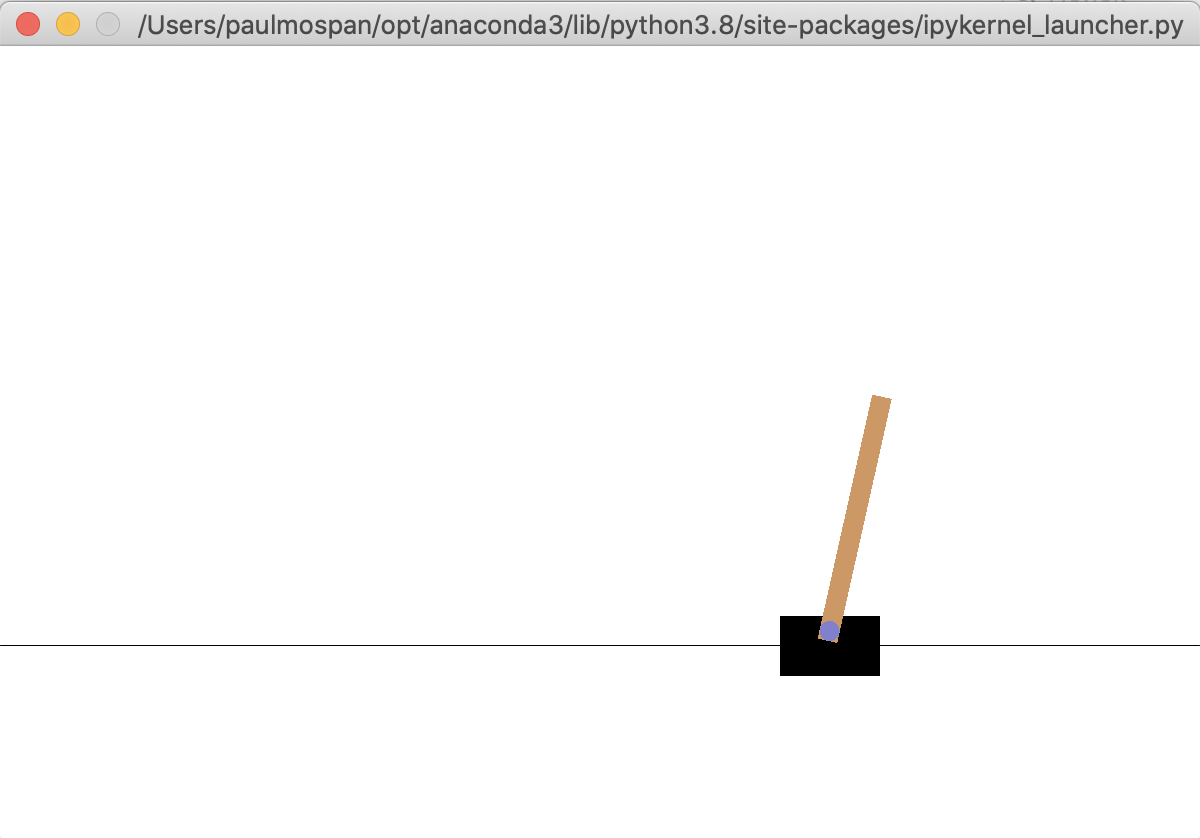